# Comparing an original Dataset with simulated Versions of it

### Choosing the dataset

In [1]:
# either diabetes_130, diabetes_012 or adult
comp_dataset='diabetes_012'

1. Loading data into pandas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator


# read csv file
if comp_dataset == 'diabetes_130':
    orig_df = pd.read_csv('./diabetes_130/diabetic_data.csv')
elif comp_dataset == 'diabetes_012':
    orig_df = pd.read_csv('./diabetes_012/diabetes_012_cleaned.csv')
elif comp_dataset == 'adult':
    orig_df = pd.read_csv('./adult/adult_cleaned.csv')

sim_df_low = pd.read_csv('./'+comp_dataset+'/simulations/low.csv')
sim_df_medium = pd.read_csv('./'+comp_dataset+'/simulations/medium.csv')
sim_df_high = pd.read_csv('./'+comp_dataset+'/simulations/high.csv')
sim_df_maximum = pd.read_csv('./'+comp_dataset+'/simulations/maximum.csv')
sim_df_westin = pd.read_csv('./'+comp_dataset+'/simulations/westin.csv')
sim_df_karampela = pd.read_csv('./'+comp_dataset+'/simulations/karampela.csv')

dataframes = [orig_df, sim_df_low, sim_df_medium, sim_df_high, sim_df_maximum, sim_df_westin, sim_df_karampela]

In [3]:
# for diabetes_130: also loading in the mapping for attributes admission_type_id, discharge_disposition_id and admission_source_id
if comp_dataset == 'diabetes_130': 
    admission_type_id = pd.read_csv('./diabetes_130/IDS_mapping.csv', nrows=8)
    discharge_disposition_id = pd.read_csv('./diabetes_130/IDS_mapping.csv', skiprows=10, nrows=30)
    admission_source_id = pd.read_csv('./diabetes_130/IDS_mapping.csv', skiprows=42, nrows=25)

In [4]:
# clean attributes
orig_df.replace('Unknown/Invalid', '?', inplace=True)

# add column amount_changed to dataframe
orig_df['amount_changed'] = pd.Series()

# change the NaN values in the column 'amount_changed' to 0
orig_df['amount_changed'].fillna(0, inplace=True)

# add column uniqueness to dataframe
for df in dataframes:
    df['uniqueness'] = pd.Series()
    # change the NaN values in the column 'uniqueness' to 0
    df['uniqueness'].fillna(0, inplace=True)

In [5]:
# demographic attributes depending on the data set 

if comp_dataset == 'diabetes_130':
    attributes = ['age', 'weight', 'gender', 'race']
elif comp_dataset == 'diabetes_012':
    attributes = ['Sex', 'Education', 'Age', 'Income']
elif comp_dataset == 'adult':
    attributes = ['age', 'native-country', 'sex', 'relationship']

In [6]:
# info about the data
for df in dataframes:
    print(df.info())
    print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

2. Comparing dataset attributes

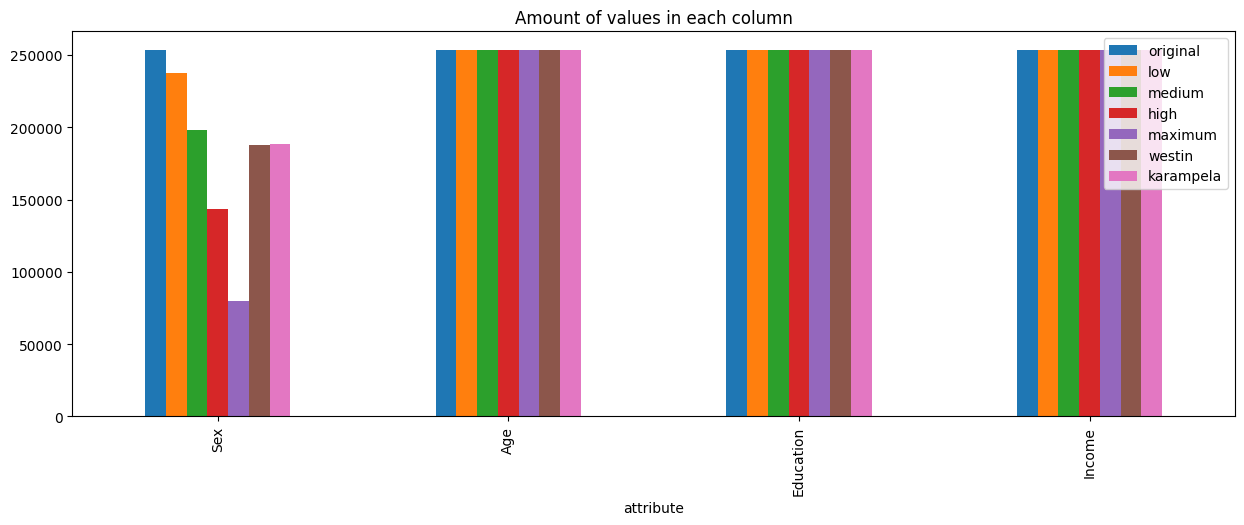

In [7]:
# finding missing values (?) in different columns
# for every column find the amount of existing values and add the count into a new dataframe count_attribute_values
count_attribute_values = pd.DataFrame(
    columns=['attribute', 'original']
)

for column in orig_df.columns:
    row_count_with_values = orig_df.loc[orig_df[column] != '?'].shape[0]
    count_attribute_values.loc[len(count_attribute_values.index)] = [column, row_count_with_values]

def add_column(column_name, df):
    count_attribute_values[column_name] = pd.Series()
    index = 0
    for column in df.columns:
        count_in_sim = df.loc[df[column] != '?'].shape[0]
        if column == orig_df[column].name:
            count_attribute_values.at[index, column_name] = count_in_sim
            index+=1
        else: 
            print('Error: column name mismatch')
            break

add_column('low', sim_df_low)
add_column('medium', sim_df_medium)
add_column('high', sim_df_high)
add_column('maximum', sim_df_maximum)
add_column('westin', sim_df_westin)
add_column('karampela', sim_df_karampela.drop(columns=['strictness']))

# plot the count_attribute_values dataframe to see the amount of missing values in each column in the original dataset
#count_attribute_values.plot.bar(x='attribute', rot=90, title='Amount of values in each column', figsize=(15, 5)).legend(loc='upper right')

if comp_dataset == 'diabetes_130':
    # only looking at the columns age, weight, sex, race
    count_attribute_values.iloc[2:6].plot.bar(x='attribute', rot=90, title='Amount of values in each column', figsize=(15, 5)).legend(loc='upper right')
elif comp_dataset == 'diabetes_012':
    # only looking at the columns Sex, Age, Education, Income
    count_attribute_values.iloc[18:22].plot.bar(x='attribute', rot=90, title='Amount of values in each column', figsize=(15, 5)).legend(loc='upper right')
elif comp_dataset == 'adult':
    # only looking at the columns age, native-country, sex, relationship
    count_attribute_values.iloc[[0,7,9,13]].plot.bar(x='attribute', rot=90, title='Amount of values in each column', figsize=(15, 5)).legend(loc='upper right')


### single attribute analysation

In [8]:
# checking for '?' values in attributes
def attribute_has_empty_values(dataframe,attribute):
    if (dataframe.loc[dataframe[attribute] == '?'].empty):
        print(attribute, 'column has no "?" values')
        return False
    else:
        print(attribute, 'column has "?" values')
        return True

In [9]:
# ploting the distribution of a given attribute
def plot_attribute_distribution(dataframes, attribute):
    combined= pd.DataFrame()
    names = ['original', 'simulation low', 'simulation medium', 'simulation high', 'simulation maximum', 'simulation westin', 'simulation karampela']
    for dataframe, name in zip(dataframes, names):
        attribute_has_empty_values(dataframe, attribute)
        groupby = dataframe.groupby(attribute).size().fillna(0)
        combined = pd.concat([combined, groupby], axis=1)
        combined.rename(columns={0: name}, inplace=True)
    
    combined.plot.bar(title=(attribute+ ' distribution for compared datasets'), figsize=(10, 5), x=df.get(attribute).tolist().sort())

Sex column has no "?" values
Sex column has "?" values
Sex column has "?" values
Sex column has "?" values
Sex column has "?" values
Sex column has "?" values
Sex column has "?" values


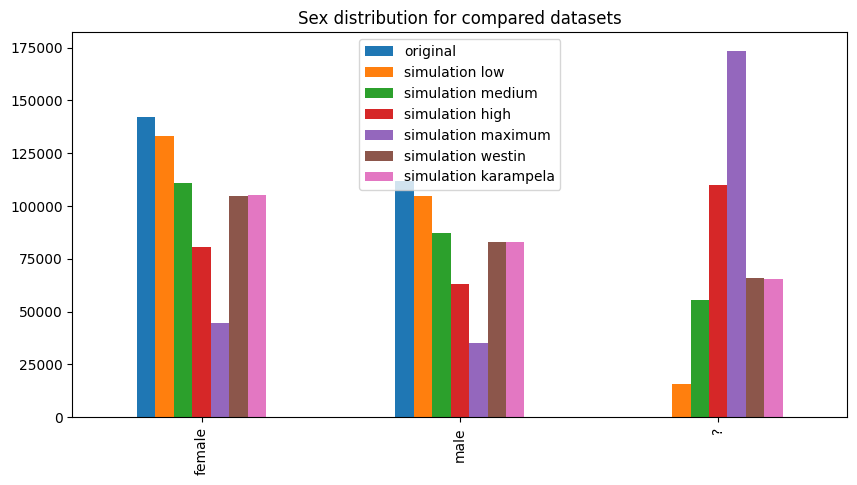

In [10]:
plot_attribute_distribution(dataframes, attributes[0])

**race**

Age column has no "?" values
Age column has no "?" values
Age column has no "?" values
Age column has no "?" values
Age column has no "?" values
Age column has no "?" values
Age column has no "?" values


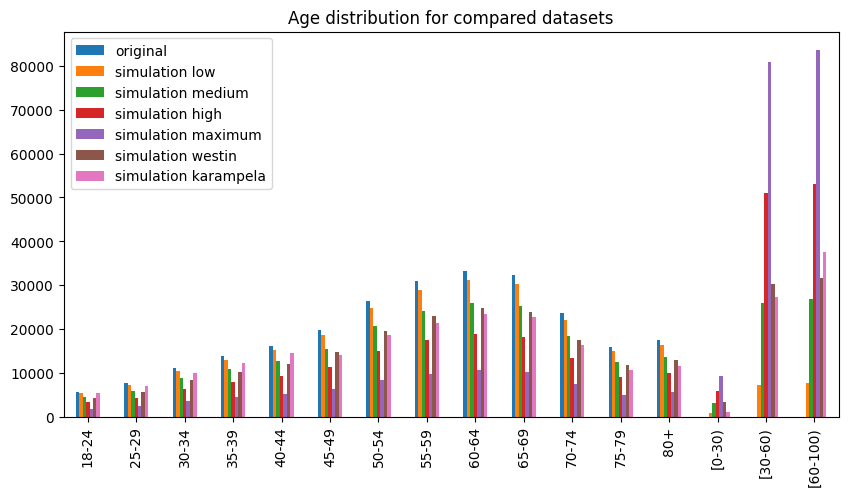

In [11]:
plot_attribute_distribution(dataframes, attributes[2])

**sex**

Income column has no "?" values
Income column has no "?" values
Income column has no "?" values
Income column has no "?" values
Income column has no "?" values
Income column has no "?" values
Income column has no "?" values


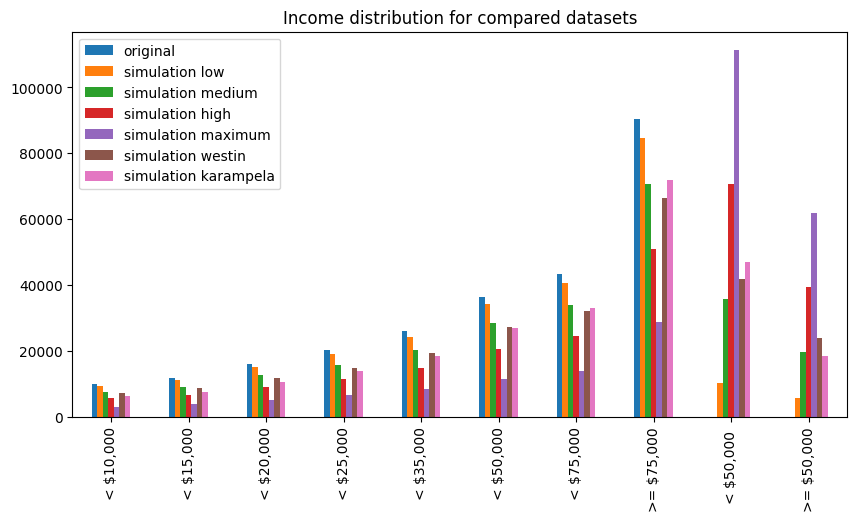

In [12]:
plot_attribute_distribution(dataframes, attributes[3])

            original    low  medium   high  maximum  westin  karampela
< $50,000        0.0  10229   35917  70664   111843   41838      46692
>= $50,000       0.0   5607   19549  39380    61639   23925      18683


/var/folders/69/knkk0bvs2zj17g66y54b741c0000gn/T/ipykernel_36008/934540942.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12)
/var/folders/69/knkk0bvs2zj17g66y54b741c0000gn/T/ipykernel_36008/934540942.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12)


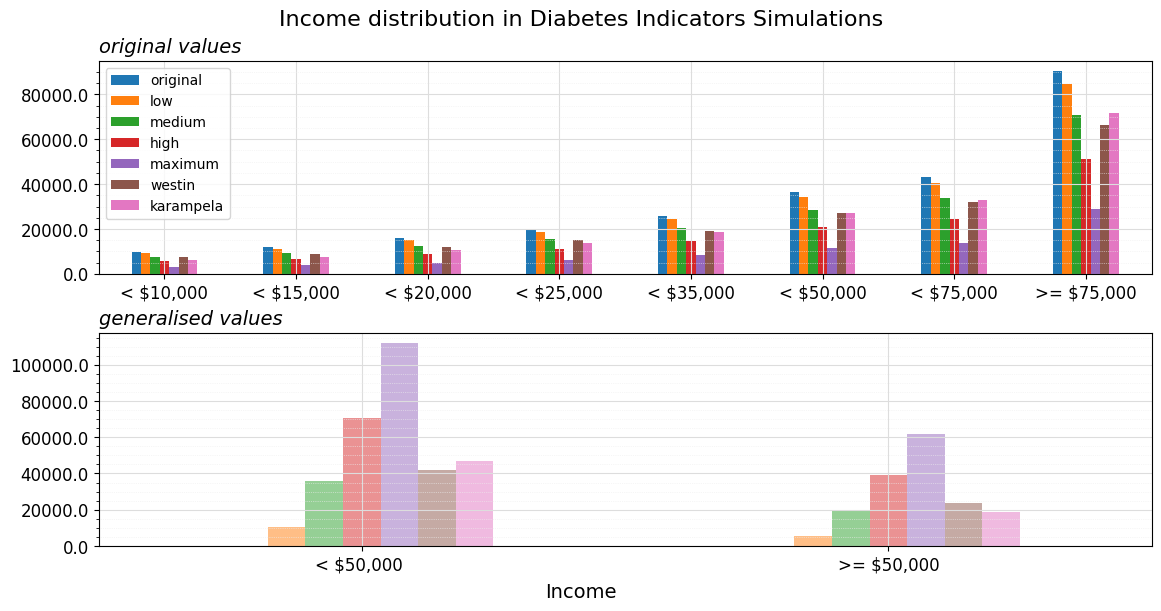

In [4]:
if comp_dataset == 'diabetes_012':
    names = ['original', 'low', 'medium', 'high', 'maximum', 'westin', 'karampela']
    def pad(dataframes, ax_array):
        ax = ax_array[0, 0]
        ax2 = ax_array[1, 0]
        combined = pd.DataFrame()
        for dataframe, name in zip(dataframes,names):
            groupby = dataframe.groupby('Income').size().fillna(0)
            combined = pd.concat([combined, groupby], axis=1)
            combined.rename(columns={0: name}, inplace=True)

        groups = combined[8:].fillna(0)
        groups = groups.reindex(['< $50,000 ', '>= $50,000'])
        print(groups)
        groups.plot.bar(ax=ax2, alpha=0.5)

        combined.drop(['< $50,000 ', '>= $50,000'], axis=0, inplace=True)
        combined.plot.bar(ax=ax)

        ax.set_xticklabels(labels = combined.index,rotation=0, fontsize=12)
        ax2.set_xticklabels(labels = groups.index,rotation=0, fontsize=12)
        ax.set_title('original values', loc='left', fontstyle='oblique', fontsize=14)
        ax2.legend().remove()
        ax2.set_title('generalised values', loc='left', fontstyle='oblique', fontsize=14)
        for ax in ax_array.flat:
            ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
            ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
            ax.yaxis.set_minor_locator(AutoMinorLocator())
            ax.set_yticklabels(ax.get_yticks(), fontsize=12)


    fig = plt.figure(figsize=(11.5, 6), layout='constrained')
    ax_array = fig.subplots(2, 1, squeeze=False, sharey=False, sharex=False)

    pad(dataframes, ax_array)


    fig.suptitle('Income distribution in Diabetes Indicators Simulations', fontsize=16)
    fig.supxlabel('Income', fontsize=14)
    plt.xticks(rotation=0)
    plt.show()


looking at the changed amount of rows and amount of changed attributes

<Axes: title={'center': 'Amount of Attributes changed for compared datasets'}, xlabel='amount_changed'>

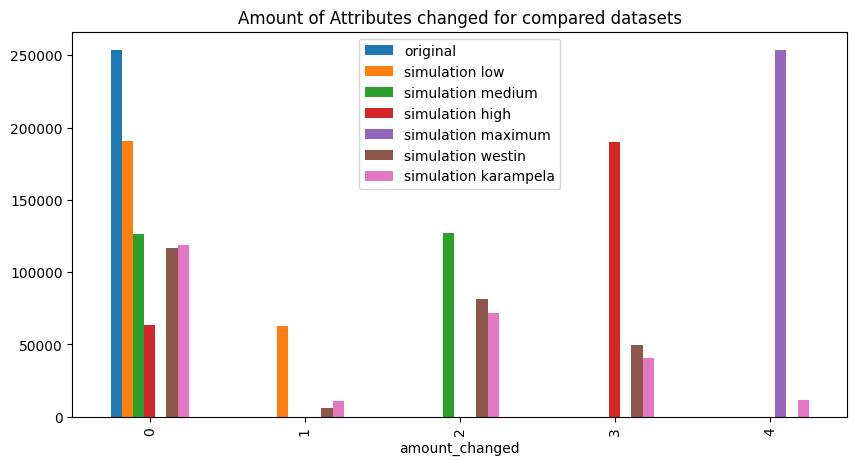

In [14]:
label_changed = pd.DataFrame({
    'original': orig_df['amount_changed'].value_counts().sort_index(),
    'low': sim_df_low['amount_changed'].value_counts().sort_index(),
    'medium': sim_df_medium['amount_changed'].value_counts().sort_index(),
    'high': sim_df_high['amount_changed'].value_counts().sort_index(),
    'maximum': sim_df_maximum['amount_changed'].value_counts().sort_index(),
    'westin': sim_df_westin['amount_changed'].value_counts().sort_index(),
    'karampela': sim_df_karampela['amount_changed'].value_counts().sort_index()
})
label_changed.plot.bar(title=('Amount of Attributes changed for compared dataset simulations'), figsize=(10, 5))


looking at readmitted patients in both datasets

In [15]:
def readmitted_df(dataframe):
    readmitted = dataframe.groupby(['age','readmitted'])['patient_nbr'].count()
    readmitted_df = readmitted.to_frame()
    readmitted_df.rename(columns={'patient_nbr': 'count'}, inplace=True)
    readmitted_df.unstack().plot(kind='area', stacked= 'False', title='readmitted patients', figsize=(15, 3))
    return readmitted_df

In [16]:
# for df in dataframes:
#     readmitted_df(df)

## Attribute Entropy

- entropy for attribute
	- wie sind die werte vorkommen in den einzelnen attributen, wie vielfältig sind die werte, die ich in einem attribut angegeben habe, desto mehr abstufungen sollten also umso weniger vielfalt bringen

In [25]:
from collections import Counter

def entropy(column, base=None):
    counts = Counter(column)
    rows = len(column)
    # probabilities for each value
    probabilities = [count / rows for count in counts.values()]
    entropy = -sum(p * np.log2(p) for p in probabilities)
    return entropy

compare entropy in simulations with original data

In [ ]:
def compare_entropy(column_name, dataframe, new_dataframe):
    demographic_attr=dataframe[attributes]
    new_dataframe[column_name] = pd.Series()
    index = 0
    for column in demographic_attr.columns:
        #print(column, entropy(demographic_attr[column]))
        if column_name == 'original':
            new_dataframe.loc[len(new_dataframe.index)] = [column, entropy(demographic_attr[column])]
            index+=1 
        else:
            new_dataframe.at[index, column_name] = entropy(demographic_attr[column])
            index+=1

names = ['original', 'low', 'medium', 'high', 'maximum', 'westin', 'karampela']
combined = pd.DataFrame(
    columns=['attribute']
)

for df, name in zip(dataframes, names):
    compare_entropy(name, df, combined)

combined.set_index('attribute', inplace=True)
combined.plot.bar(title='Entropy of quasi-identifiers', figsize=(10, 5))

## Attribute Subset

- wie oft kommt ein attribut category überhaupt vor in den einzelnen rows
- wie verändert sich die attributwert verteilung in den simulationen
- auswertung: 
    - verhältnis im subset veränderung über die simulationen, 
    - gesamtveränderung zwischen den abstufungen, 
    - informationsverlust im attribut für utility veränderung


In [17]:
def attribute_subset(dataframe, attribute):
    column = dataframe[attribute]
    nan= (column == '?').sum() # ? values
    # print(nan)
    available = dataframe.shape[0] - nan # available values
    # print(available)
    return (available/dataframe.shape[0]) # percentage of available values (x/n)

In [ ]:
def compare_subset(column_name, dataframe, new_dataframe):
    demographic_attr=dataframe[attributes]
    new_dataframe[column_name] = pd.Series()
    index = 0
    for column in demographic_attr.columns:
        #print(column, subset(demographic_attr[column]))
        if column_name == 'original':
            new_dataframe.loc[len(new_dataframe.index)] = [column, attribute_subset(demographic_attr, column)]
            index+=1 
        else:
            new_dataframe.at[index, column_name] = attribute_subset(demographic_attr, column)
            index+=1

names = ['original', 'low', 'medium', 'high', 'maximum', 'westin', 'karampela']
combined_subset = pd.DataFrame(
    columns=['attribute']
)
for df, name in zip(dataframes, names):
    compare_subset(name, df, combined_subset)  

combined_subset.set_index('attribute', inplace=True)
combined_subset.plot.bar(title='Subsets of quasi-identifiers', figsize=(10, 5))